# Using `dask` with Scanpy

:::{warning} 🔪 **Beware sharp edges!** 🔪

`dask` support in `scanpy` is new and highly experimental!

Many functions in `scanpy` **do not** support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::

[`dask`](https://www.dask.org) is a popular out-of-core, distributed array processing library that scanpy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

This notebook relies on optional dependencies in dask and `sklearn_ann` and `annoy`. Install them with:

```sh
pip install -U "dask[array,distributed,diagnostics]" sklearn_ann annoy
```

In [1]:
from pathlib import Path

import numpy as np
import dask.distributed as dd
import scanpy as sc
import anndata as ad
import h5py

sc.logging.print_header()

/ictstr01/home/icb/ilan.gold/scanpy-tutorials/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.0rc2.dev103+gc6766d75 anndata==0.11.0.dev157+ge0b81f1.d20240812 umap==0.5.6 numpy==2.0.1 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


Here, we'll be working with a moderately large dataset of 1.4 million cells taken from: [COVID-19 immune features revealed by a large-scale single-cell transcriptome atlas](https://cellxgene.cziscience.com/collections/0a839c4b-10d0-4d64-9272-684c49a2c8ba)

In [2]:
if not Path("cell_atlas.h5ad").exists():
    !wget https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad -O "cell_atlas.h5ad"

For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html). In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use. It's very likely you will have to tune the number of workers and amount of memory per worker along with your chunk sizes.

In [3]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)

2024-08-12 23:15:37,758 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1390s; attempting restart: <WorkerState 'tcp://127.0.0.1:35183', name: 1, status: running, memory: 0, processing: 0>
2024-08-12 23:15:39,079 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1323s; attempting restart: <WorkerState 'tcp://127.0.0.1:36599', name: 2, status: running, memory: 0, processing: 0>
2024-08-12 23:15:39,252 - distributed.scheduler - WARNING - Worker failed to heartbeat for 1323s; attempting restart: <WorkerState 'tcp://127.0.0.1:36805', name: 0, status: running, memory: 0, processing: 0>
2024-08-12 23:15:43,529 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-08-12 23:15:43,641 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-08-12 23:15:43,645 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2024-08-12 23:15:43,683 - distributed.nanny - 

:::{note}
In this notebook we will be demonstrating some computations in scanpy that use `scipy.sparse` classes within each dask chunk. Be aware that this is currently poorly supported by `dask`, and that if you want to interact with the `dask` arrays in any way other than though the `anndata` and `scanpy` libraries you will likely need to densify each chunk.

All operations in `scanpy` and `anndata` that work with sparse chunks also work with dense chunks.

The advantage of using sparse chunks are:

* The ability to work with fewer, larger chunks
* Accelerated computations per chunk (e.g. don't need to `sum` all those extra zeros)

You can convert from `sparse` to `dense` chunks via:

```python
X = X.map_blocks(lambda x: x.toarray(), dtype=X.dtype, meta=np.array([]))
```

And in reverse:

```python
X = X.map_blocks(sparse.csr_matrix)
```

Note that you will likely have to work with smaller chunks when doing this, via a rechunking operation. We suggest using a factor of the larger chunk size to achieve the most efficient rechunking.

:::

In [4]:
SPARSE_CHUNK_SIZE = 100_000
DENSE_CHUNK_SIZE = 10_000

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 18,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37191,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:36805,Total threads: 6
Dashboard: http://127.0.0.1:45909/status,Memory: 42.67 GiB
Nanny: tcp://127.0.0.1:39225,


We'll convert the `X` representation to `dask` using `anndata.experimental.read_elem_as_dask`.

The file we've retrieved from cellxgene has already been processed. Since this tutorial is demonstrating processing from counts, we're just going to access the counts matrix and annotations.

In [6]:
%%time
with h5py.File("cell_atlas.h5ad", "r") as f:
    adata = ad.AnnData(
        obs=ad.experimental.read_elem(f["obs"]),
        var=ad.experimental.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_as_dask(
        f["raw/X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
    )

CPU times: user 2.4 s, sys: 673 ms, total: 3.08 s
Wall time: 3.22 s


We've optimized a number of scanpy functions to be completely lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediately.

In [7]:
%%time
adata.layers["counts"] = adata.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 7.1 ms, sys: 31 μs, total: 7.13 ms
Wall time: 7.49 ms


In [8]:
%%time
sc.pp.log1p(adata)

CPU times: user 3.14 ms, sys: 2.03 ms, total: 5.17 ms
Wall time: 4.88 ms


Highly variable genes needs to add entries into `obs`, which currently does not support lazy column. So computation will occur immediately on call.

In [9]:
%%time
sc.pp.highly_variable_genes(adata)

CPU times: user 3.46 s, sys: 509 ms, total: 3.97 s
Wall time: 50 s


PCA currently does not support sparse data. So we will need to densify the expression matrix before passing it in. However, as we are working with only a subset of the data at a time, we are able to perform this operation with a lower memory overhead.

As this is a still a significant increase in memory usage per chunk, we will need to reduce the number of observations present in each chunk.

In [10]:
adata.layers["dense"] = adata.X.rechunk((DENSE_CHUNK_SIZE, -1)).map_blocks(
    lambda x: x.toarray(), dtype=adata.X.dtype, meta=np.array([])
)

In [11]:
%%time
sc.pp.pca(adata, layer="dense")

CPU times: user 9.31 s, sys: 1.19 s, total: 10.5 s
Wall time: 1min 27s


While most of the PCA computation runs immediately, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.

In [12]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

CPU times: user 6.72 s, sys: 1.36 s, total: 8.08 s
Wall time: 1min 15s


In [13]:
adata

AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', '

Now that we've computed our PCA let's take a look at it:

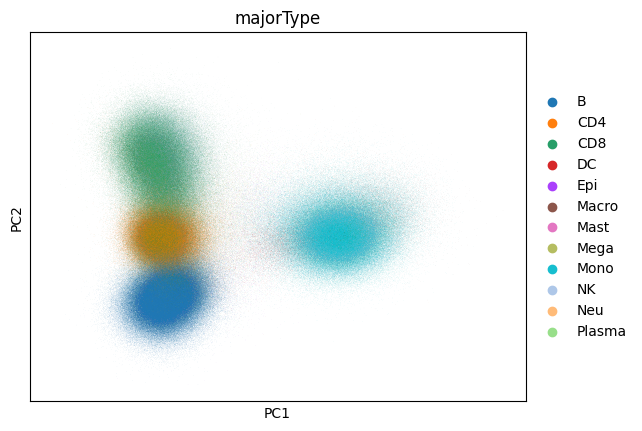

In [14]:
sc.pl.pca(adata, color="majorType")

Further support for `dask` is a work in progress. However, many operations past this point can work with the dimensionality reduction directly in memory. With scanpy `1.10` many of these operations can be accelerated to make working with large datasets significantly easier. For example:

* Using alternative KNN backends for faster neighbor calculation {doc}`/how-to/knn-transformers`
* Using the `igraph` backend for clustering

In [15]:
%%time
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # noqa: E402

transformer = AnnoyTransformer(n_neighbors=15)
sc.pp.neighbors(adata, transformer=transformer)

CPU times: user 1min 32s, sys: 2.64 s, total: 1min 35s
Wall time: 1min 9s


In [16]:
%%time
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

CPU times: user 1min 40s, sys: 6.24 s, total: 1min 46s
Wall time: 1min 46s


UMAP computation can still be rather slow, taking longer than the rest of this notebook combined:

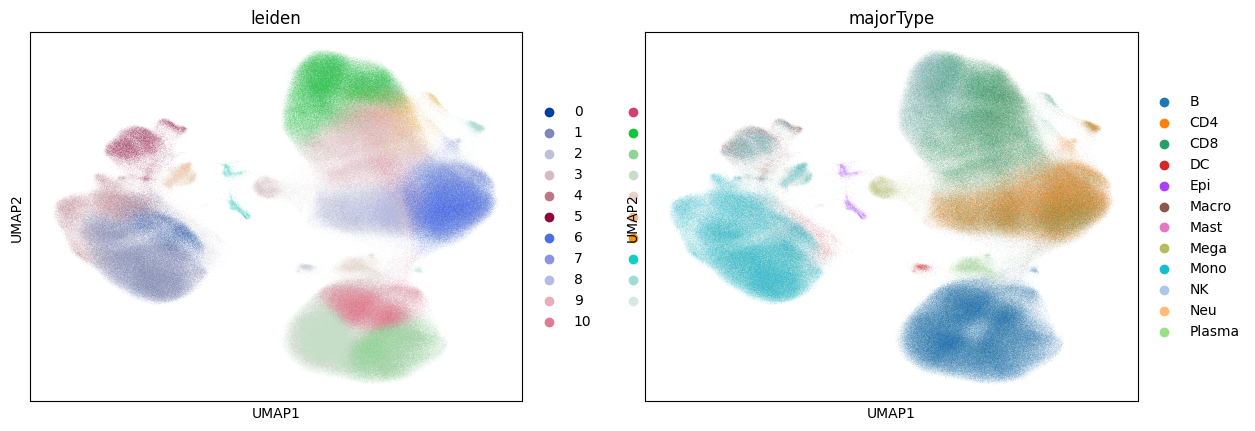

CPU times: user 3h 13min 5s, sys: 32.2 s, total: 3h 13min 37s
Wall time: 37min 55s


In [17]:
%%time
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "majorType"])